<div>
    <img src="./images/sunpy_logo.png" width="500" align="left"/>
    <br clear="left"/> <!-- This line ensures that the text appears below the image -->
</div>

# Example notebook and exercises!

Now using all the information we have learned, lets analyse the flare event that occured on 2022-04-02 13:00 that was observed by Solar Orbiter and Earth.

As part of this notebook, I'll show some example workflow analysis you could do - but as an exercise, I suggest that you go through our documentation on [sunpy.org](https://sunpy.org/) and our [affiliated packages](https://sunpy.org/affiliated/) (e.g. [sunkit-image](https://docs.sunpy.org/projects/sunkit-image/en/latest/), [sunkit-instrument](https://docs.sunpy.org/projects/sunkit-instruments/en/stable/), and through the [example gallery](https://docs.sunpy.org/en/stable/generated/gallery/index.html) to see what more fun analysis you could do!

In [870]:
import astropy.units as u
from astropy.coordinates import SkyCoord

from sunpy.net import Fido, attrs as a
from sunpy.time import parse_time
import sunpy.map
import sunpy.timeseries as ts
from sunpy.coordinates import frames, get_horizons_coord
from astropy.visualization import ImageNormalize
import sunpy_soar
from aiapy.calibrate import register, update_pointing
import os

import numpy as np
import glob
import matplotlib.pyplot as plt
from sunpy.physics.differential_rotation import solar_rotate_coordinate
from matplotlib import colors

Lets first create a search and download data of interest, for this, lets build a Fido query like before.

Lets first search for GOES XRS data

In [871]:
xrs_res = Fido.search(a.Time("2022-04-02 12:50", "2022-04-02 15:00"), 
                      a.Instrument.xrs, a.goes.SatelliteNumber(16), a.Resolution.flx1s)

In [872]:
xrs_res

Start Time,End Time,Instrument,SatelliteNumber,Physobs,Source,Provider,Resolution
Time,Time,str3,int64,str10,str4,str4,str5
2022-04-02 00:00:00.000,2022-04-02 23:59:59.999,XRS,16,irradiance,GOES,NOAA,flx1s


In [873]:
Fido.fetch(xrs_res, path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['XRS/sci_xrsf-l2-flx1s_g16_d20220402_v2-2-0.nc']

In [874]:
goes_xrs = ts.TimeSeries("./XRS/sci_xrsf-l2-flx1s_g16_d20220402_v2-2-0.nc")

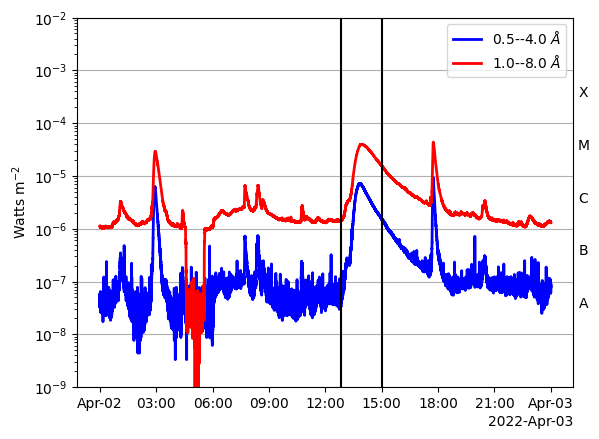

In [875]:
fig, ax = plt.subplots()
goes_xrs.plot()
ax.axvline(parse_time("2022-04-02 12:50").datetime, color='k')
ax.axvline(parse_time("2022-04-02 15:00").datetime, color='k')


Lets now search for AIA 171 Å data and Solar Orbiter EUI/FSI 174 Å data between teh vertical lines in teh GOES/XRS plot over the flare of interest

In [876]:
image_res = Fido.search(a.Time("2022-04-02 12:50", "2022-04-02 15:00"),
                       (a.Instrument.aia & a.Wavelength(171*u.angstrom) & a.Sample(10*u.min)) | 
                       (a.Instrument.eui & a.Level(2) & a.soar.Product("EUI-FSI174-IMAGE")))

In [877]:
Fido.fetch(res, path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/26 [00:00<?, ?file/s]

['AIA/aia_lev1_171a_2022_04_02t12_50_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t13_00_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t13_10_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t13_20_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t13_30_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t13_40_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t13_50_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t14_00_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t14_10_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t14_20_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t14_30_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t14_40_09_35z_image_lev1.fits', 'AIA/aia_lev1_171a_2022_04_02t14_50_09_35z_image_lev1.fits', 'EUI/solo_L2_eui-fsi174-image_20220402T125045230_V01.fits', 'EUI/solo_L2_eui-fsi174-image_20220402T130045231_V01.fits', 'EUI/solo_L2_eui-fsi174-image_20220402T131045269_V01.fits', 'EUI/solo_L2_eui-fsi174-im

In [878]:
aia_files = glob.glob("./AIA/*171a*.fits"); aia_files.sort()
eui_files = glob.glob("./EUI/*fsi174*.fits"); eui_files.sort()

In [879]:
aia_files

['./AIA/aia_lev1_171a_2022_04_02t12_00_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t12_10_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t12_20_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t12_30_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t12_40_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t12_50_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t13_00_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t13_10_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t13_20_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t13_30_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t13_40_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t13_50_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t14_00_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t14_10_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t14_20_09_35z_image_lev1.fits',
 './AIA/aia_lev1_171a_2022_04_02t14_30_0

In [880]:
aia_maps = sunpy.map.Map(aia_files)

In [881]:
eui_maps = sunpy.map.Map(eui_files)

(<matplotlib.patches.Polygon at 0x158893f20>,
 <matplotlib.patches.Polygon at 0x15b7b40e0>)

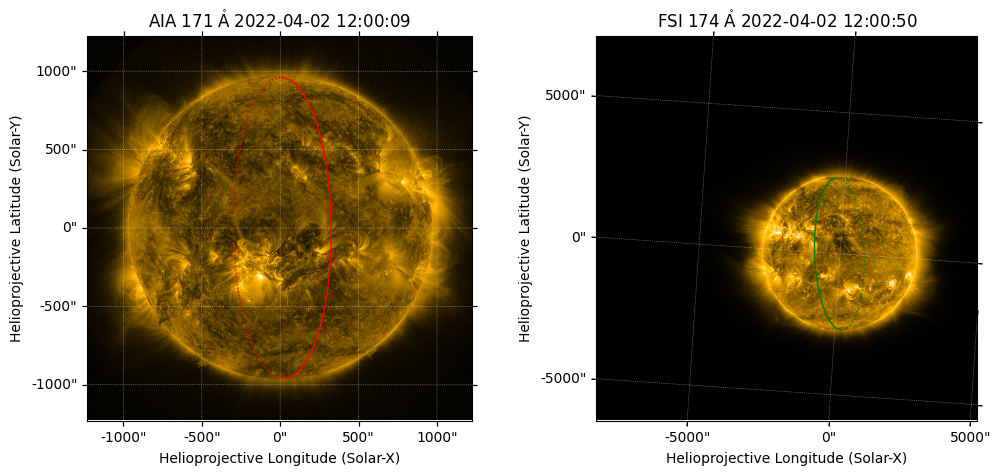

In [882]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection=aia_maps[0])
ax2 = fig.add_subplot(1, 2, 2, projection=eui_maps[0])

aia_maps[0].plot(axes=ax1)
eui_maps[0].draw_limb(color='r', axes=ax1)
eui_maps[0].plot(axes=ax2)
aia_maps[0].draw_limb(color='g', axes=ax2)


## Prep AIA data from Level 1 to Level 1.5

To do this we will use sunpy's affiliated package `aiapy`

In [883]:
aia_maps[0].meta["lvl_num"]

1.0

In [884]:
m_updated_pointing = update_pointing(aia_maps[0])
m_registered = register(m_updated_pointing)

In [885]:
m_registered.meta["lvl_num"]

1.5

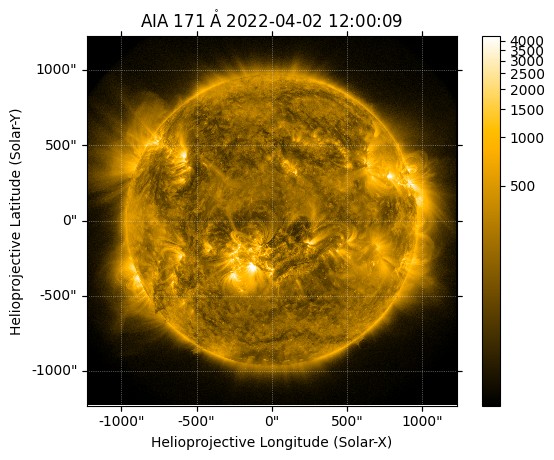

In [886]:
m_registered.plot(clip_interval=[5, 99.98]*u.percent)
plt.colorbar()

## TO DO: Try write a function that takes the input of an AIA map and updates the pointing and registers it to a Level 1.5 map 

Try yourself to do this

## Lets zoom in and rotate EUI maps

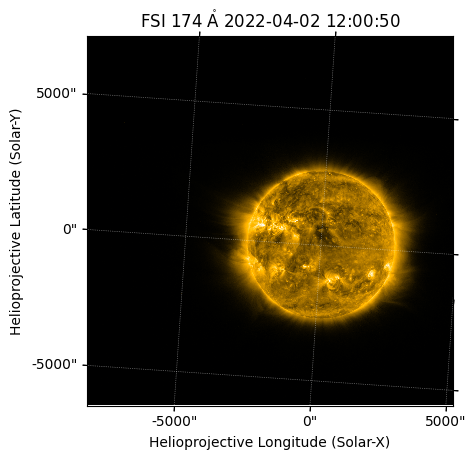

In [887]:
eui_maps[0].plot()

In [888]:
def make_zoom_eui(m):
    bl = SkyCoord(-5000*u.arcsec, -5000*u.arcsec, frame=m.coordinate_frame)
    tr = SkyCoord(5000*u.arcsec, 5000*u.arcsec, frame=m.coordinate_frame)
    return m.submap(bl, top_right=tr).rotate(missing=m.data.min())

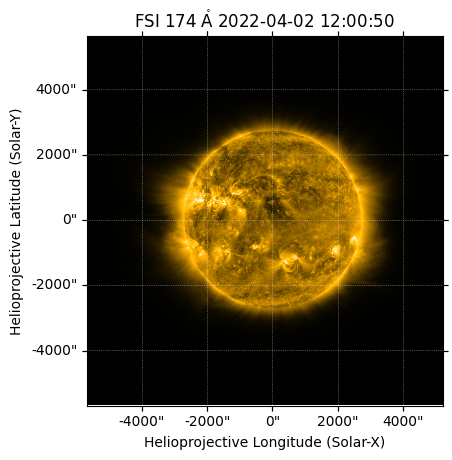

In [889]:
make_zoom_eui(eui_maps[0]).plot()

In [895]:
bl = SkyCoord(700*u.arcsec, 200*u.arcsec, frame=aia_maps[0].coordinate_frame)
tr = SkyCoord(850*u.arcsec, 400*u.arcsec, frame=aia_maps[0].coordinate_frame)


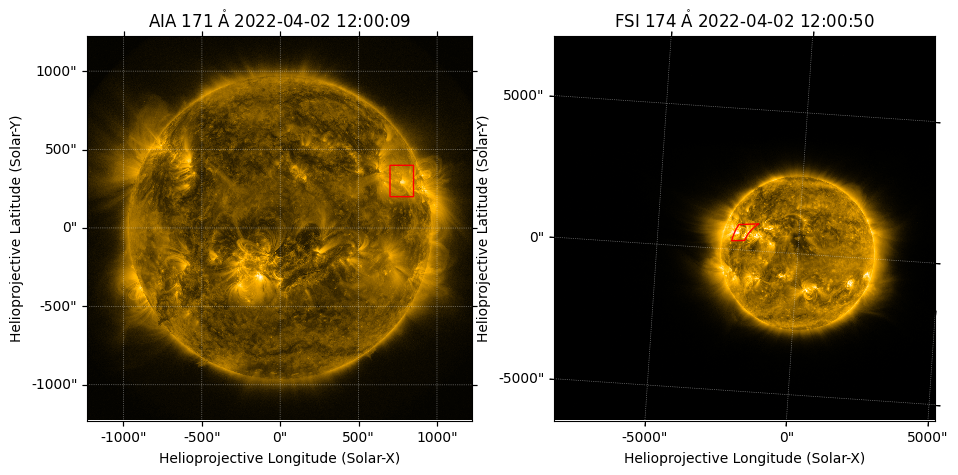

In [896]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1, 2, 1, projection=aia_maps[0])
ax2 = fig.add_subplot(1, 2, 2, projection=eui_maps[0])
aia_maps[0].plot(axes=ax1)
aia_maps[0].draw_quadrangle(bl, top_right=tr, axes=ax1, edgecolor='r')

eui_maps[0].plot(axes=ax2)
eui_maps[0].draw_quadrangle(bl, top_right=tr, axes=ax2, edgecolor='r')

## TO DO: crop all the EUI maps to this field of view

## Lets look at SOHO LASCO C2 data

For this example, lets demonstrate how you can use jp2 files from helioviewer. Using hvpy, we can download jp2 files. Here, we'll use sunpy to find times for which there is SOHO LASCO C2 data, and then we'll use hvpy to download the processed jp2 LASCO C2 files, and use sunpy to read and plot them.

In [897]:
result = Fido.search(a.Time("2022-04-02 12:50", "2022-04-02 17:00"),
                     a.Instrument.lasco,
                     a.Detector.c2)

In [898]:
if not os.path.exists("./LASCO_C2"):
    os.mkdir("LASCO_C2")

lasco_files = []
for i in range(len(result["VSO"])):
    time_map = parse_time(result["VSO"]["Start Time"].datetime).datetime[i]
    cor2_file = hvpy.save_file(hvpy.getJP2Image(time_map,
                                                hvpy.DataSource.LASCO_C2.value),
                               "./LASCO_C2/lasco_c2_{:s}.jp2".format(time_map.strftime("%Y%m%d%H%M%S")), 
                               overwrite=True)
    lasco_files.append(cor2_file)

In [899]:
lasco_files = glob.glob("./LASCO_C2/*.jp2"); lasco_files.sort()
lasco_maps = sunpy.map.Map(lasco_files, sequence=True)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


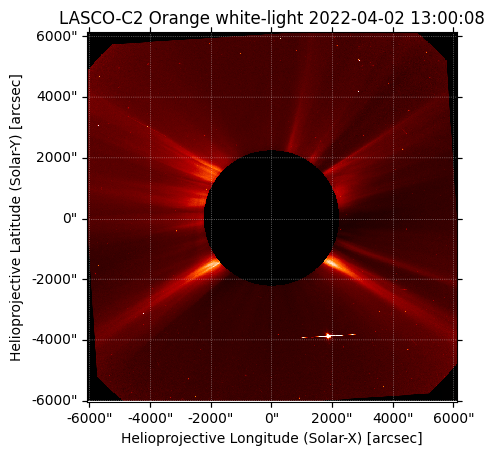

In [900]:
fig = plt.figure()
ani = lasco_maps.plot(norm=ImageNormalize(vmin=0, vmax=250,
                                          stretch=lasco_maps[0].plot_settings['norm'].stretch))
ani.save('lasco-maps-seq.mp4', fps=15, dpi=300)

# Lets plot the AIA and LASCO C2 map together

One thing to be aware of, is that given that the times and teh positions of the spacecraft are different (even though small), they have a different WCS. Hence to plot them on the same plot, we need to reproject one map to another. Here lets reproject the aia map to the lasco map wcs. One final thing to note is that the `rsun_ref` should be the same for both maps. Please read this topic guide about this: https://docs.sunpy.org/en/stable/topic_guide/rsun.html

In [903]:
aia_maps[6].meta["rsun_ref"] = sunpy.sun.constants.radius.to_value(u.m)
lasco_maps[0].meta["rsun_ref"] = sunpy.sun.constants.radius.to_value(u.m)

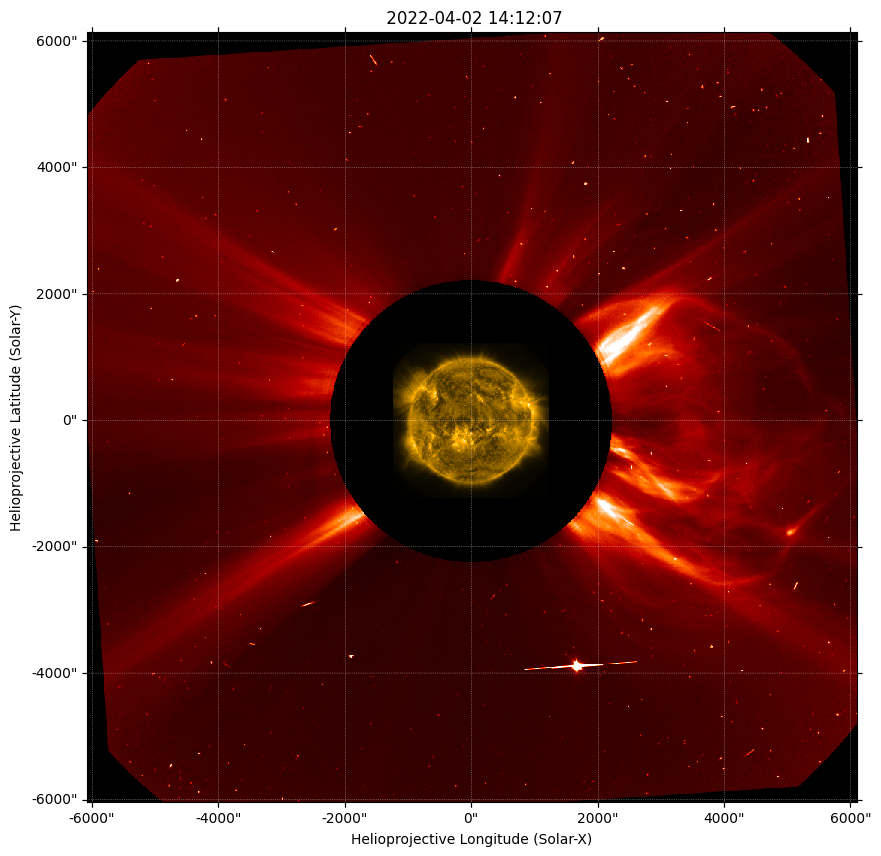

In [906]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(projection=lasco_maps[6])
lasco_maps[6].plot(vmin=0, vmax=250)
with frames.Helioprojective.assume_spherical_screen(lasco_maps[6].observer_coordinate):
    aia_map_lasco_wcs = aia_maps[13].resample([250, 250]*u.pix).reproject_to(lasco_maps[6].wcs)
aia_map_lasco_wcs.plot()


## Find HEK areas on the Sun

Lets now show an example of querying the Helio Event Knowledgebase (HEK) to find active regions around the time of thh flare event. Lets first start with finding HMI magnetogram data, and then querying active region data

In [907]:
res = Fido.search(a.Time("2022-04-02 12:00", "2022-04-02 13:00"), 
                  a.Instrument.hmi, a.Physobs.los_magnetic_field)

In [908]:
hmi_file = Fido.fetch(res[0][0], path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [909]:
hmi_map = sunpy.map.Map(hmi_file)

In [910]:
hmi_rotated = hmi_map.rotate(order=3)


In [911]:
hek_results = Fido.search(a.Time("2022-04-02 12:01", "2022-04-02 14:00"),
                              a.hek.AR, a.hek.FRM.Name=='HMI SHARP')

In [912]:
hek_results["hek"]["event_starttime", "event_endtime"]

event_starttime,event_endtime
Time,Time
2022-04-02 12:00:00.000,2022-04-02 16:00:00.000
2022-04-02 12:00:00.000,2022-04-02 16:00:00.000
2022-04-02 12:00:00.000,2022-04-02 16:00:00.000
2022-04-02 12:00:00.000,2022-04-02 16:00:00.000
2022-04-02 12:00:00.000,2022-04-02 16:00:00.000
2022-04-02 12:00:00.000,2022-04-02 16:00:00.000
2022-04-02 12:00:00.000,2022-04-02 16:00:00.000
2022-04-02 12:00:00.000,2022-04-02 16:00:00.000
2022-04-02 12:00:00.000,2022-04-02 16:00:00.000


In [913]:
ar_areas = []
for i in range(len(hek_results["hek"])):
    ch = hek_results["hek"][i]
    p1 = ch["hpc_bbox"][9:-2].split(',')
    coord_values = [v.split(" ") for v in p1]
    ch_date = parse_time(ch['event_starttime'])
    ch_boundary = SkyCoord(
        [(float(v[0]), float(v[1])) * u.arcsec for v in coord_values],
        obstime=ch_date, observer="earth",
        frame=frames.Helioprojective)
    #rotated_ch_boundary = solar_rotate_coordinate(ch_boundary, observer=hmi_map.observer_coordinate)
    ar_areas.append(ch_boundary)


In [914]:
hek_results["hek"]["ar_noaanum"]

12976
12978
None
12983
None
12979
12986
12982
None
None
12985


In [915]:
for ar in ar_areas:
    print(ar.obstime)

2022-04-02 12:00:00.000
2022-04-02 12:00:00.000
2022-04-02 12:00:00.000
2022-04-02 12:00:00.000
2022-04-02 12:00:00.000
2022-04-02 12:00:00.000
2022-04-02 12:00:00.000
2022-04-02 12:00:00.000
2022-04-02 12:00:00.000
2022-04-02 12:00:00.000
2022-04-02 13:12:00.000


In [916]:
hmi_rotated.meta["rsun_ref"] = eui_maps[0].meta["rsun_ref"]

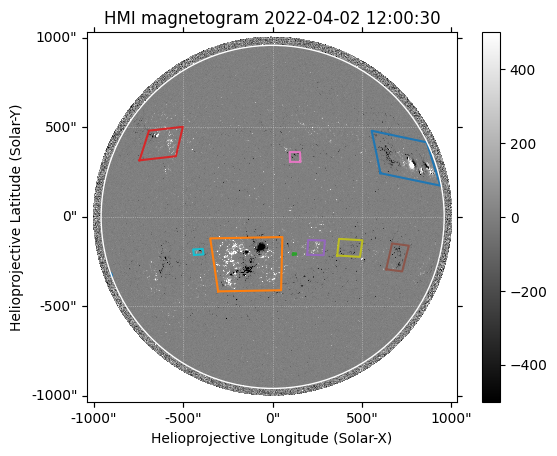

In [917]:
fig = plt.figure()
ax = fig.add_subplot(projection=hmi_rotated)
hmi_rotated.plot(axes=ax, norm=colors.Normalize(vmin=-500, vmax=500))
hmi_rotated.draw_limb()
for ar in ar_areas:
    ax.plot_coord(ar)

plt.colorbar()
plt.show()

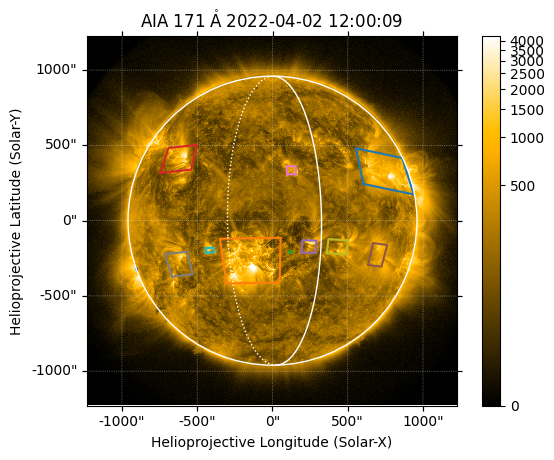

In [918]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_maps[0])
aia_maps[0].plot(axes=ax, clip_interval=[2, 99.98]*u.percent)
aia_maps[0].draw_limb()
for ar in ar_areas:
    ax.plot_coord(ar)
eui_maps[0].draw_limb()
plt.colorbar()
plt.show()

(<matplotlib.patches.Polygon at 0x15bf4f1d0>,
 <matplotlib.patches.Polygon at 0x15be17ad0>)

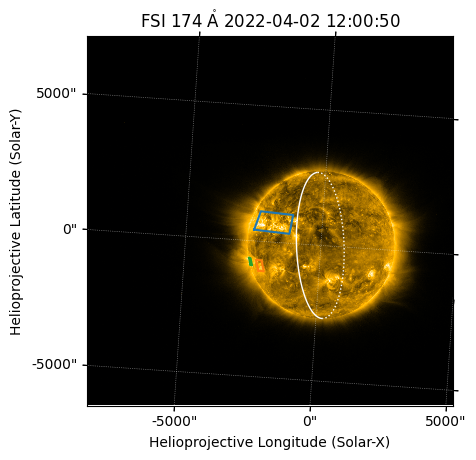

In [919]:
eui_maps[0].plot()
ax = plt.gca()
for ar in ar_areas:
    transformed_coords = ar.transform_to(eui_maps[0].coordinate_frame)
    if np.any(transformed_coords.is_visible(tolerance=1*u.km)):
        ax.plot_coord(transformed_coords[transformed_coords.is_visible(tolerance=1*u.km)])
hmi_map.draw_limb()